<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/SARSA_semigradiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de SARSA semi-gradiente sobre el entorno Mountain Car

*Description*: En este notebook se desarrolla la implementación del método de **SARSA semi-gradiente**, y se emplea sobre el entorno Mountain Car de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09

In [ ]:
import random
import gymnasium as gym
from gymnasium import ObservationWrapper
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

SEED = 123

## Entorno MountainCar

**Mountain Car** es otro entorno clásico del framework de Gymnasium. Hasta ahora hemos estado trabajando con el entorno sencillo de Frozen Lake (aunque el caso 8x8, no siempre resultaba sencillo), el cual, resultaba ser un buen entorno para poner en práctica los distintos métodos tabulares que hemos visto en la asignatura (Monte Carlo, SARSA y Q-learning). No obstante, estos métodos se encuentran limitados por la representación que tienen de los $Q$ valores para obtener la política. En casos en los que los estados son continuos, debemos de llevar a cabo distintas técnicas para poder trabajar con estos entornos.

Mountain Car es uno de estos entornos más "complicados". A pesar de que su espacio de acciones es sencillo, pues estamos usando la versión v0, donde las acciones están discretizadas en:
  * 0: acelera a la izquierda.
  * 1: no acelera.
  * 2: acelera a la derecha.

El espacio de estados/observaciones es continuo, con dos dimensiones:
  * Dimensión 0: Posición del coche a lo largo del eje x. Máx: 0.6; Min:-1.2.
  * Dimensión 1: Velocidad del coche. Máx: 0.07; Min: -0.07.

  Por terminar de explicar ya del todo el entorno que vamos a emplear, su sistema de recompensas es dar un valor de -1 por cada instante de tiempo que pasa en el episodio. De esta manera, se incentiva a la obtención del objetivo lo antes posible.

  

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()

(array([-0.5125705,  0.       ], dtype=float32), {})

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
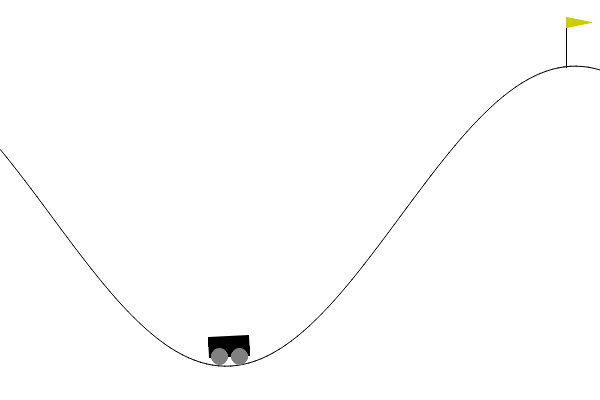

In [ ]:
env.render()

De esta manera, se pone de manifiesto la necesidad de usar un método de aproximación, alternativo a los métodos tabulares empleados, pues ya no podemos definir, de la misma forma que hemos venido haciendo, los valores Q. Para solventar esto, en lugar de tomar $Q$, como una tabla, vamos a tomarla como una función que mapea valores de estado y acción, a valores $Q$. Existen diversas manera de obtener esta función, pero la que se corresponde con el método que analizamos en este notebook se basa en los métodos lineales.

En estos métodos, los valores $Q$ se obtienen mediante las operaciones lineales entre un **vector de características**, que representa el estado $s$, $x(s)$, y unos pesos $w$, que serán los que deberá de ir aprendiendo el agente a medida que explore el entorno:

$$
\hat{q}(s,a,w) = w^\intercal x(s, a) = \sum_{i=1}^d w_i x_i(s, a)
$$

Donde $\hat{q}(s,a,w)$ es el valor aproximado de la función $Q(s,a)$, $w$ el vector de parámetros a obtener, y $x(s,a) el vector de características generado por distintas técnicas de contrucción de características para métodos lineales. La más usada y la que mejor funciona es el **Tiling encoding**, o codificación por teselados, que explicaremos en la siguiente sección.

## Extensión de la clase ObservationWrapper de Gymnasium para discretizar estados continuos

Acabamos de motivar el uso de métodos de aproximación para el entorno de Mountain Car, y hemos hablado de la base del método que desarrollamos en este notebook. En esta sección, desarrollamos un wrapper de gymnasium, para poder discretizar el espacio de observaciones del entorno.

**Tile Coding** divide el espacio de estados en regiones o "tiles" (azulejos). Cada división recibe el nombre mosaicos (rejillas o tiling).

La idea principal es cubrir el espacio de estados con varias rejillas (tilings) que se superponen. Cada rejilla divide el espacio en celdas (tiles) y está ligeramente desplazada respecto a las otras. Esto permite que cada punto del espacio se asocie a varios tiles, uno por cada rejilla.

Para un estado dado, representado con un punto, se determina en qué teselas cae en cada una de las rejillas. Esto permite definir un vector binario (el vector de características que definíamos antes), **$x(s,a)$**, donde cada componente indica si un tile específico está activo (por ejemplo, con valor 1) o no (valor 0). La mayoría de componentes son 0 y unas pocas son 1, correspondientes a los tiles activos).

Siguiendo el notebook `AproximacionFuncionesLineales.ipynb` de las prácticas de la asignatura, utilizamos el wrapper desarrollado, que discretiza el espacio de observaciones de dos dimensiones de Mountain Car.

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=10)

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.

class TileCodingEnv(ObservationWrapper):
    """
    TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.
    Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas,
    permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.
    """

    def __init__(self, env, bins, low, high, n=4):
        """
        Inicializa el entorno env con tile coding.

        Parámetros:
        - env: entorno original de Gym.
        - bins: array o lista con el número de intervalos (bins) que hay que particionar cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - n: número de tilings (rejillas) a crear (por defecto 4).

        Se llama al método _create_tilings para generar las rejillas desplazadas.
        """
        super().__init__(env)  # Llama al constructor de la clase padre ObservationWrapper.

        # Guardamos atributos útiles para calcular las features solo una vez.
        self.bins = bins              # Ej.: np.array([10, 10])
        self.n_tilings = n            # Número de tilings.
        self.tile_size = int(np.prod(bins))  # Número de celdas en cada tiling.
        self.last_active_features = None     # Aquí se guardarán las features activas de la última observación

        self._high = high
        self._low = low

        self.tilings = self._create_tilings() # (bins, high, low, n)  # Crea y almacena las tilings.

        # el vector de observación tendrá C componentes. Por ejemplo, para 2 dimensiones × 4 tilings = C = 8.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()*n)



    def observation(self, obs):  # Es necesario sobreescribir este método de ObservationWrapper
        """
        Transforma una observación continua en una representación discreta usando tile coding.

        Parámetro:
        - obs: observación continua proveniente del entorno.

        Para cada tiling en self.tilings, se determina el índice (bin) para cada dimensión usando np.digitize.
        Se devuelve una lista de tuplas de índices, una por cada tiling.
        Antes de retornar, se calcula y almacena en self.last_active_features el conjunto de índices
        activos (flattened) usando _get_active_features().

        Retorna:
        - indices: lista de tuplas de índices, una por cada tiling.

        """
        indices = []  # Lista que almacenará los índices discretizados para cada tiling.
        for t in self.tilings:
            # Para cada tiling 't', se calcula el índice en el que se encuentra cada componente de la observación.
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)  # Se agrega la tupla de índices correspondiente a la tiling actual.

        # Calcula y guarda las features activas a partir de los índices obtenidos.
        self.last_active_features = self._get_active_features(indices)
        return indices # Retorna la lista de índices de todas las tilings.


    def _get_active_features(self, tiles):
        """
        Método privado para calcular los índices (features) activos en la función aproximada.

        Parámetro:
        - tiles: lista de tuplas (una por tiling) obtenida de observation(), donde cada tupla
          contiene los índices discretizados para cada dimensión.

        La función realiza lo siguiente:
          1. Convierte cada tupla de índices a un índice plano usando np.ravel_multi_index(tile, bins).
            - Dado que `tile` es una tupla de índices - por ejemplo, `(3, 5)` , y
            - dado que `bins` indica las particiones en cada dimensión - por ejemplo `bins = [10, 10]``
            - entonces `(3, 5)` se mapea a  3*10 + 5 = 35
            - Este índice plano identifica de forma única una celda dentro de una tiling.

          2. Asigna a cada tiling un bloque distinto en el vector de parámetros, de forma que:
             feature = (índice del tiling * tile_size) + índice plano.
             - Por ejemplo, con dos tilings, si en ambos se selecccionara el tile `(3, 5)`
             - Para el tiling 0 (i = 0), el flat_index será 35 (como se ha calculado antes)
             - Pero para el tiling 1 (i=1), el flat_index será 1*100+35=135

        Retorna:
        - features: lista de índices únicos (enteros) que indican las características activas.
        """
        features = []
        for i, tile in enumerate(tiles):
            # Convierte la tupla 'tile' a un índice plano.
            flat_index = np.ravel_multi_index(tile, self.bins)
            # Asigna a cada tiling un bloque único: para el tiling i, los índices van desde i*tile_size hasta (i+1)*tile_size - 1.
            feature = i * self.tile_size + flat_index
            features.append(feature)
        return features



    def _create_tilings(self): # , bins, high, low, n):
        """
        Crea 'n' tilings (rejillas) desplazadas para el tile coding.

        Parámetros:
        - bins: número de intervalos (bins) en cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - n: número de tilings a crear.

        El proceso consiste en:
         1. Generar un vector de desplazamientos base (displacement_vector) para cada dimensión.
         2. Para cada tiling, se ajustan los límites 'low' y 'high' añadiéndoles un pequeño desplazamiento aleatorio.
         3. Se calculan los tamaños de los segmentos en cada dimensión (segment_sizes).
         4. Se determinan desplazamientos específicos para cada dimensión y se aplican a los límites.
         5. Finalmente, se generan los buckets (límites discretos) para cada dimensión usando np.linspace.

        Retorna:
        - tilings: una lista donde cada elemento es una tiling (lista de arrays de buckets para cada dimensión).
        """
        # Se genera un vector de desplazamientos en cada dimensión en base a los números impares.
        # P.e. Si hay 2 dimensiones (len(bins) == 2): np.arange(1, 2 * 2, 2) -> np.arange(1, 4, 2) devuelve [1, 3]
        #      Si la dimensión 1 se desplaza en 1 unidad, en la dimensión 2 se desplazará en 3 unidades.
        # P.e. Si hay 3 dimensiones (len(bins) == 3): np.arange(1, 2 * 3, 2) -> np.arange(1, 6, 2) devuelve [1, 3, 5]
        # P.e. Si hay 4 dimensiones (len(bins) == 4): np.arange(1, 2 * 4, 2) -> np.arange(1, 8, 2) devuelve [1, 3, 5, 7]
        # Y así sucesivamente.
        # displacement_vector se ajusta automáticamente generando un array de números impares
        # Estos valores se usan posteriormente para calcular los desplazamientos específicos en cada dimensión al crear las tilings (rejillas).
        # ¿Por qué esos valores? Porque son los recomendados: los primeros números impares.
        displacement_vector = np.arange(1, 2 * len(bins), 2)


        tilings = []  # Lista que almacenará todas las tilings generadas.
        for i in range(0, self.n_tilings):
            # Para cada tiling 'i', se calculan nuevos límites 'low_i' y 'high_i' con un desplazamiento aleatorio.
            # El desplazamiento aleatorio se basa en el 20% de los límites originales.
            low_i = self._low  # - random.random() * 0.2 * low
            high_i = self._high # + random.random() * 0.2 * high

            # Vamos a calcular el desplazamiento específico para cada dimensión y cada mosaico.

            # Antes calculamos displacement_vector, que nos indica el desplazamiento en cada dimensión.
            # Como tenemos varios mosaicos, cada uno se tendrá que desplazar
            # en la mismas cantidades con respecto al mosaico anterior.
            # Esto se puede conseguir multiplicando el displacement_vector por el número de mosaico (i),
            # pero se toma el módulo n (número total de mosaicos).
            # De esta forma el desplazamiento de cada mosaico es diferente, dentro del rango [0, n-1]

            # P.e. Para n=4 mosaicos, y dos dimensiones, los vectores de desplazamiento de cada mosaico son:
            # i = 1: [1, 3] = [1, 3] * 1 % 4 = [1, 3] % 4
            # i = 2: [2, 2] = [1, 3] * 2 % 4 = [2, 6] % 4
            # i = 3: [3, 1] = [1, 3] * 3 % 4 = [3, 9] % 4
            # i = 4: [0, 0] = [1, 3] * 4 % 4 = [4, 12] % 4
            displacements = displacement_vector * i % self.n_tilings

            # Pero hay que escalar el desplazamiento a unidades reales en cada dimensión.
            # Para ello necesitamos calcular el tamaño de cada segmento (intervalo) en cada dimensión.
            segment_sizes = (high_i - low_i) / self.bins

            # Entonces usamos una fracción del tamaño del segmento para desplazar cada mosaico.
            # La fracción del tamaño del segmento viene dado por el tamaño del segmento dividido por el número de mosaicos.
            # Por ejemplo, si el tamaño de la celda es 0.5 en la primera dimensión y se consideran n=4 mosaicos, la fracción es 0.5/4=0.125
            # Según se ha calculado anteriormente, en el vector de desplazamiento,
            # la primera dimensión se desplaza en 1, 2, 3 y 0 unidades para los mosaicos 1, 2, 3, y 4, respectivamente.
            # Como la unidad es 0.125, entonces la primera dimensión de cada mosaico se desplaza en las cantidades:
            # 0.125 = 1 * 0.125,  0.25 = 2 * 0.125, 0.375 = 3 * 0.125, y  0 = 0 * 0.125.
            # Lo mismo se haría con el resto de dimensiones. En forma vectorial:
            # Es decir, el desplazamiento de cada mosaico en la primera dimensión es:
            # Tiling 1, [1, 3]: [1 * 0.125, 3 * 0.05] = [0.125, 0.15]
            # Tiling 2, [2, 2]: [2 * 0.125, 2 * 0.05] = [0.25, 0.10]
            # Tiling 3, [3, 1]: [3 * 0.125, 1 * 0.05] = [0.375, 0.05]
            # Tiling 4  [0, 0]: [0 * 0.125, 0 * 0.05] = [0, 0]
            displacements = displacements * (segment_sizes / self.n_tilings)

            dlow_i = low_i + displacements
            dhigh_i = high_i + displacements
            # print(f"Tiling {i}: Se aplican los desplazamientos {displacements} a los límites inferiores {low_i}->{dlow_i} y superiores {high_i}->{dhigh_i}.")

            # Para cada dimensión, se crean los buckets que dividen el intervalo de low_i a high_i en 'bins' partes,
            # generando 'l-1' puntos (límites) para cada dimensión.
            buckets_i = [np.linspace(j, k, l - 1) for j, k, l in zip(dlow_i, dhigh_i, bins)]

            # Se añade la tiling actual (lista de buckets para cada dimensión) a la lista de tilings.
            tilings.append(buckets_i)

        return tilings  # Retorna la lista completa de tilings.

Vamos a discretizar el espacio de estados de Mountain Car usando 10 tiles, donde estos se encuentran superpuestos, consiguiendo así que estados cercanos, no se representen como muy distintos tras realizar la discretización. Para cada tile, usaremos 20 bins por dimensión, obteniendo un mosaico de 400 celdas, buscando así no discretizar demasiado, y no perder tanta información así. El nuevo entorno será `tcenv`.

In [ ]:
tilings = 10  # Número de mosaicos
bins = np.array([20, 20])  # Número de intervalos en cada dimensión. 20 en cada una
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

Ploteamos el siguiente ejemplo para hacernos una idea de como funciona el wrapper:

In [ ]:
print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio original es: {env.step(env.action_space.sample())}")
print(f"\nEl espacio de estados modificado es: {tcenv.observation_space}. Mosaicos: {tcenv.n_tilings} \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")
print(f"Las caracterísiticas observadas han sido {tcenv.last_active_features} sobre {np.prod(tcenv.bins)*tcenv.n_tilings} parámetros")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio original es: (array([-4.0864372e-01,  1.5592630e-04], dtype=float32), -1.0, False, False, {})

El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]). Mosaicos: 10 
Un estado para este nuevo espacio es: [(8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico
Las caracterísiticas observadas han sido [170, 569, 969, 1369, 1769, 2169, 2569, 2969, 3369, 3769] sobre 4000 parámetros


## Definción del agente

Una vez que hemos discretizado el espacio de observaciones, vamos a ver cómo es el diseño del agente, para que use **SARSA semi-gradiente**. La política que usa este método es una $\epsilon$-greedy, tan vista en la asignatura. Lo interesante del método, como viene siendo habitual, es su forma de obtener los valores que determinan la política.

La **regla de actualización general**, consiste en la siguiente ecuación de actualización de los pesos **$w$**:

$$
w ← w + \alpha [R + \gamma \hat{q}(S', A', w) - \hat{q}(S, A, w)] \nabla_w \hat{q}(S, A, w)
$$

Donde $\alpha$ es la tasa de aprendizaje, $\gamma$ es el factor de descuento, y **$R$** es la recompensa obtenida tras la transición $(S, A) → (S', A')$.

Como comentábamos al inicio del notebook, la **función aproximada** que estamos asumiendo es $\hat{q}(s, a, w) = w^\intercal x(s, a)$, donde **$x(s, a)$** es el **vector de características** que obtenemos gracias al tiling anterior.

Por último, se necesita calcular $\nabla_w \hat{q}(S, A, w)$, pero dado que $\hat{q}$ es lineal, la derivada con respecto a $w$ es simplemente:

$$
\nabla_w\hat{q}(S, A, w) = x(s,a)
$$

Por tanto, tenemos que los pesos se actualizan:

$$
w ← w + \alpha [R + \gamma \hat{q}(S', A', w) - \hat{q}(S, A, w)] x(S, A)
$$

No obstante, antes hablábamos de la utilidad de usar **tiling encoding** para la discretización de los estados. Entre otras, una de ellas es que, el vector **$x(s, a)$** es un vector compuesto por 1s en los índices de los tiles activos (10), y 0s en el resto, por lo que la actualización de los pesos sólo se lleva a cabo para aquellos correspondientes con los índices de los tilings activos.

In [ ]:
class AgentSARSA_semigrad:
  def __init__(self,
               tcenv:TileCodingEnv, # entorno discretizado con tiling coding
               epsilon:float,
               max_steps:int,
               gamma:float,
               alpha:float,
               decay:bool
               ):

    # Inicializamos atributos del agente
    self.tcenv = tcenv

    # Número de acciones del entorno original
    self.n_actions = self.tcenv.env.action_space.n
    # Número total de caracterísitcas en el aproximador lineal
    self.total_features = self.tcenv.n_tilings * np.prod(self.tcenv.bins)
    # Inicializamos los pesos (por ejemplo, a cero)
    self.weights = np.zeros((self.total_features, self.n_actions))

    self.epsilon = epsilon
    self.max_steps = max_steps
    self.gamma = gamma
    self.alpha = alpha
    self.alpha_ini = alpha
    self.decay = decay

  def q_value(self, active_features, a):
    return self.weights[active_features, a].sum()

  def compute_q_values(self, active_features):
    q_vals = np.zeros(self.n_actions)
    for a in range(self.n_actions):
        q_vals[a] = self.q_value(active_features, a)
    return q_vals

  def epsilon_greedy_policy(self, active_features):
    # Obtenemos los Q-values para cada acción, y determinar, en el caso greedy, aquella que tenga mayor valor
    q_vals = self.compute_q_values(active_features)
    # Con probabilidad epsilon se escoge una acción aleatoria (exploración)
    if np.random.random() < self.epsilon:
      return self.tcenv.env.action_space.sample()
    else:
      # Con probabilidad 1-epsilon se escoge la mejor acción (explotación)
      return np.argmax(q_vals)

  def greed_action(self, active_features):
    q_vals = self.compute_q_values(active_features)
    return np.argmax(q_vals)

  #def decay_epsilon(self):
  #  self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

  #def decay_alpha(self):
  #  self.alpha = max(self.alpha * self.alpha_decay, self.alpha_min)


  def update(self, active_features, action, reward, active_features_next, next_action, done, truncated):
    # Calcular Q(s,a) para el estado actual y la acción tomada
    q_sa = self.q_value(active_features, action)
    # Si no es estado terminal, calcular Q(s',a')
    if not (done or truncated):
        q_sap = self.q_value(active_features_next, next_action)
        delta = reward + self.gamma * q_sap - q_sa
    else:
        delta = reward - q_sa

    # Actualizar los pesos solo en las features activas para la acción 'a'
    for i in active_features:
        self.weights[i, action] += self.alpha * delta

## Esquema general del aprendizaje episódico (Algoritmo)

El esquema general de aprendizaje, es similar al de SARSA, pero adaptado para trabajar con vectores de características, en lugar de con estados. Una de las cosas a destacar es el uso de decaimiento, en este caso no para $\epsilon$, sino para $\alpha$. Como veíamos en el apartado anterior, un factor clave en la actualización de los pesos $w$, es el factor de aprendizaje $\alpha$. Aplicar un factor de decaimiento del alpha, va a hacer que, en instantes iniciales, los valores de $Q$ cambien brucamente, para luego, con el paso del tiempo, ir reduciéndose para así estabilizar la política y la actualización de estos valores.

In [ ]:
def train(agent, num_episodes):
  returns = []  # Para guardar la recompensa total de cada episodio
  len_episodes = [] # Para guardar la longitud de los episodios
  step_display = num_episodes / 10
  np.random.seed(SEED)

  for episode in tqdm(range(num_episodes)):
    # Resetear el entorno (Gymnasium devuelve (obs, info))
    obs, info = agent.tcenv.reset(seed=SEED)
    # El método observation() del wrapper actualiza internamente tcenv.last_active_features.
    active_features = agent.tcenv.last_active_features
    # Seleccionar acción inicial usando epsilon-greedy
    a = agent.epsilon_greedy_policy(active_features)

    # Recompensa total del episodio
    total_reward = 0.0
    # Longitud del episodio
    len_episode = 0
    done = False

    # Aplicamos decaimiento de la epsilon a partir del episodio 1000
    if agent.decay:
      agent.alpha = min(agent.alpha_ini, 1/(1+0.1*episode))#min(agent.epsilon, 200/(episode+1))

    for t in range(agent.max_steps):

      # Ejecutar la acción 'a' y obtener la siguiente observación
      obs_next, reward, done, truncated, info = agent.tcenv.step(a)
      total_reward += reward

      # Después de step, tcenv.last_active_features se actualiza para el nuevo estado s' (active_features es el state (S) de los metodos tabulares)
      active_features_next = agent.tcenv.last_active_features

      # Seleccionar la siguiente acción a' (si el episodio continúa)
      if not (done or truncated):
        a_next = agent.epsilon_greedy_policy(active_features_next)
      else:
        a_next = None  # No se usa si es terminal

      # Actualizamos los pesos
      agent.update(active_features, a, reward, active_features_next, a_next, done, truncated)

      if done or truncated:
        break

      # Actualiza estado y acción para el siguiente paso
      active_features = active_features_next
      a = a_next
      len_episode += 1

    # Almacenamos la recompensa del episodio
    returns.append(total_reward)
    # Almacenamos la longitud del episodio
    len_episodes.append(len_episode)
    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
      print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}; len_episode: {len_episode}; epsilon: {agent.epsilon}")

  # Después de entrenar, puedes evaluar la política (por ejemplo, sin exploración)
  avg_return = np.mean(returns)
  print(f"Average return over {num_episodes} episodes: {avg_return}")
  return returns, len_episodes

Desarrollamos esta función para, una vez entrenado el agente, evaluar su aprendizaje en el entorno, mediante un video.

In [ ]:
def run_episode_greedy(agent, max_steps=200):
  frames = []
  obs, info = agent.tcenv.reset(seed=SEED)

  active_features = agent.tcenv.last_active_features
  a = agent.greed_action(active_features)

  total_reward = 0.0
  len_episode = 0

  for t in range(max_steps):
    frame = agent.tcenv.env.render()
    frames.append(frame)

    obs_next, reward, done, truncated, info = agent.tcenv.step(a)
    total_reward += reward
    active_features_next = agent.tcenv.last_active_features
    if not (done or truncated):
      a_next = agent.greed_action(active_features_next)
    else:
      a_next = None  # No se usa si es terminal
    if done or truncated:
      break
    active_features = active_features_next
    a = a_next
    len_episode += 1

  return total_reward, len_episode, frames

## Funciones auxiliares

Funciones comúnes que usaremos en todos los notebooks. Serán para visualizar la política greedy final obtenida, el vídeo del comportamiento final del agente, así como las gráficas que nos provean de información intuitiva de la evolución del proceso de aprendizaje.

In [ ]:
import imageio

def frames_to_gif(frames, filename="MountainCar_sarsa.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [ ]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [ ]:
def plot(list_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(10, 4))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

def plot_comparative(dict_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios de cada elemento de la lista.
    list_stats: Es un diccionario, donde cada clave contiene la información de un agente.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(dict_stats['decay=True'])))
  plt.figure(figsize=(10, 4))

  for key in dict_stats:
    plt.plot(indices, dict_stats[key], label=key)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')
  plt.legend()

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [ ]:
from scipy import stats

def moving_average(data, window_size):
    '''
      Calcula la media móvil de una serie de datos, para una window_size dada.
    '''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_len_tendency(list_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia.
  '''

  plt.figure(figsize=(10, 4))

  plt.plot(list_len, alpha=0.3, color='green')

  # Curva de media móvil
  window = 100
  avg = moving_average(list_len, window_size=window)
  plt.plot(range(len(avg)), avg, label="Longitud del episodio", color='darkgreen', linewidth=2)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_len_comparative(dict_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia, de cada elemento del diccionario.
  '''
  color = ['darkred', 'darkblue', 'darkgreen']

  plt.figure(figsize=(10, 4))
  # Curva de media móvil
  window = 100
  for i, key in enumerate(dict_len):
    plt.plot(dict_len[key], alpha=0.2, color=color[i])
    avg = moving_average(dict_len[key], window_size=window)
    plt.plot(range(len(avg)), avg, label=key, linewidth=2, color=color[i])

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

## Entrenamiento

Vamos a entrenar al agente en el entorno de Mountain Car. No obstante, ya no vamos a probar con un número tan elevado de episodios, como sí que hacíamos en los experimentos con los métodos tabulares. En este caso vamos a probar con 10000 episodios.

Además, vamos a evaluar la efectividad de aplicar decaimiento al $\alpha$, para ver cómo se mejora el entrenamiento tras estabilizar este en los episodios finales, y priorizar una actualización más agresiva en los primeros episodios.

En el agente con decay, empezaremos con un $\alpha_0 = 0.1$, y el decaimiento, como veíamos en la implementación del esquema de entrenamiento episódico, será inversamente prorcional al número de episodios.

In [ ]:
n_episodes = 10000

agent = AgentSARSA_semigrad(tcenv=tcenv, epsilon=0.3, max_steps=200, gamma=0.99, alpha=0.1, decay=True)
returns, len_episodes = train(agent, n_episodes)

 10%|█         | 1005/10000 [01:01<06:57, 21.54it/s]

Episode 1001/10000, total reward: -148.0; len_episode: 147; epsilon: 0.009900990099009901


 20%|██        | 2004/10000 [02:02<06:33, 20.30it/s]

Episode 2001/10000, total reward: -156.0; len_episode: 155; epsilon: 0.004975124378109453


 30%|███       | 3003/10000 [03:02<05:42, 20.42it/s]

Episode 3001/10000, total reward: -150.0; len_episode: 149; epsilon: 0.0033222591362126247


 40%|████      | 4005/10000 [03:57<04:29, 22.26it/s]

Episode 4001/10000, total reward: -154.0; len_episode: 153; epsilon: 0.0024937655860349127


 50%|█████     | 5003/10000 [04:51<04:07, 20.19it/s]

Episode 5001/10000, total reward: -148.0; len_episode: 147; epsilon: 0.001996007984031936


 60%|██████    | 6003/10000 [05:44<04:27, 14.93it/s]

Episode 6001/10000, total reward: -158.0; len_episode: 157; epsilon: 0.0016638935108153079


 70%|███████   | 7003/10000 [06:38<02:25, 20.57it/s]

Episode 7001/10000, total reward: -159.0; len_episode: 158; epsilon: 0.0014265335235378032


 80%|████████  | 8004/10000 [07:30<01:35, 20.90it/s]

Episode 8001/10000, total reward: -145.0; len_episode: 144; epsilon: 0.0012484394506866417


 90%|█████████ | 9005/10000 [08:24<00:44, 22.61it/s]

Episode 9001/10000, total reward: -146.0; len_episode: 145; epsilon: 0.0011098779134295228


100%|██████████| 10000/10000 [09:20<00:00, 17.85it/s]

Average return over 10000 episodes: -162.1193


Probamos el entrenamiento de otro agente que use un $\alpha$ fijo, y evaluar la efectividad del decay.

In [ ]:
agent_2 = AgentSARSA_semigrad(tcenv=tcenv, epsilon=0.3, max_steps=200, gamma=0.99, alpha=0.1, decay=False)
returns_2, len_episodes_2 = train(agent, n_episodes)

 10%|█         | 1003/10000 [01:07<09:15, 16.20it/s]

Episode 1001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.009900990099009901


 20%|██        | 2003/10000 [02:14<07:35, 17.54it/s]

Episode 2001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.004975124378109453


 30%|███       | 3003/10000 [03:22<10:00, 11.66it/s]

Episode 3001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0033222591362126247


 40%|████      | 4004/10000 [04:29<05:50, 17.11it/s]

Episode 4001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0024937655860349127


 50%|█████     | 5003/10000 [05:36<05:41, 14.62it/s]

Episode 5001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.001996007984031936


 60%|██████    | 6003/10000 [06:43<05:31, 12.05it/s]

Episode 6001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0016638935108153079


 70%|███████   | 7004/10000 [07:51<03:15, 15.31it/s]

Episode 7001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0014265335235378032


 80%|████████  | 8004/10000 [09:00<02:00, 16.57it/s]

Episode 8001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0012484394506866417


 90%|█████████ | 9002/10000 [10:07<01:24, 11.84it/s]

Episode 9001/10000, total reward: -200.0; len_episode: 199; epsilon: 0.0011098779134295228


100%|██████████| 10000/10000 [11:15<00:00, 14.81it/s]

Average return over 10000 episodes: -199.9826


In [ ]:
dict_stats = {'decay=True': returns, 'decay=False': returns_2}
dict_len = {'decay=True': len_episodes, 'decay=False': len_episodes_2}

Hemos aprovechado la función que plotea la tendencia de la longitud de los episodios para evaluar la tendencia de las recompensas (en este caso, hemos almacenado la recompensa por episodio, y no la promedio).

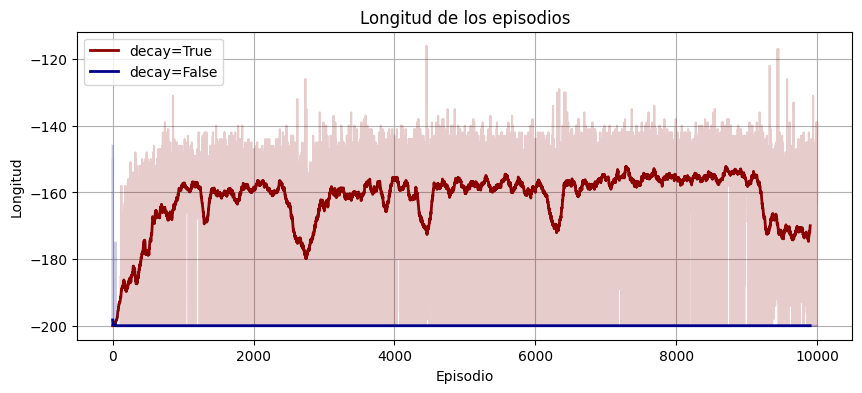

In [ ]:
plot_len_comparative(dict_stats)

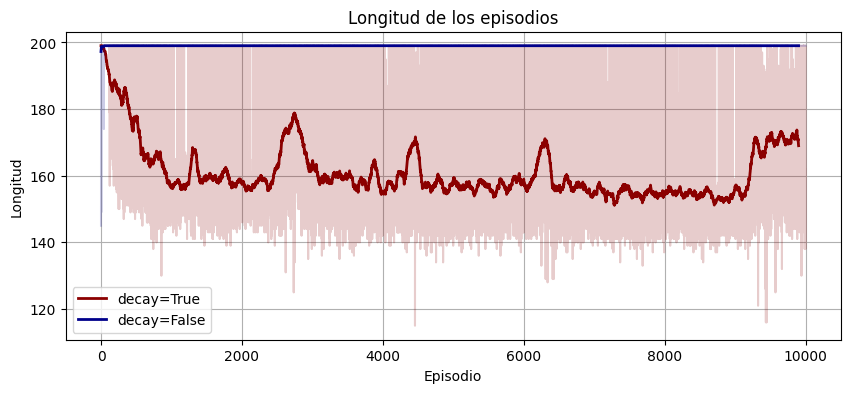

In [ ]:
plot_len_comparative(dict_len)

Visualizando los resultados vemos como, el caso de no usar decay, ya sea por la semilla usada, o por lo que sea, parece haber encontrado una política subóptima que lo deja estancado, sin posibilidad de encontrar la solución en ningún episodio (y eso que la $\epsilon$ estaba fija a un valor considerable 0.3). No obstante, el uso del decay del $\alpha$ como veníamos anticipando, ha resultado ser de gran ayuda para el método, consiguiendo alcanzar el objetivo en buena parte de los episodios, aunque de manera poco eficiente, pues tarda un tiempo alto en conseguirlo.

Fijémonos además en cómo una gráfica es la inversa de la otra, debido al reparto de recompensas que tiene este entorno. Por cada instante de tiempo se nos da una recompensa de -1, equivalente a sumarle 1 a la longitud del episodio, por lo que usando una de ellas hubiese sido sufiente.

## Evaluación

Observando el vídeo vemos como el coche tarda en llegar al objetivo, pues no realiza el camino óptimo, pero ha aprendido a alcanzarlo de todas formas.

In [ ]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent)

# Crear el GIF a partir de los fotogramas capturados.
gif_path = frames_to_gif(frames)
print("GIF guardado en:", gif_path)

GIF guardado en: MountainCar_sarsa.gif


In [ ]:
display_gif(gif_path)